In [1]:
!pip3 install -Uqq fastbook
!pip3 install graphviz -q
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [7]:
# Let's open all images from the folders and convert them 
# into a tensors (n-dimentional arrays) and create an array out of them

threes_tensors = [tensor(Image.open(o)) for o in threes]
sevens_tensors = [tensor(Image.open(o)) for o in sevens]

In [8]:
# Now let's stack them and create a single tensor
stacked_threes = torch.stack(threes_tensors).float()/255
stacked_sevens = torch.stack(sevens_tensors).float()/255

In [9]:
#check dimensions
stacked_threes.ndim

3

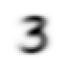

In [10]:
# Compute how ideal three would look like by averaging pixels in all images
mean3 = stacked_threes.mean(0)
show_image(mean3);

<AxesSubplot:>

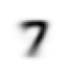

In [11]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

 - Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm
 - Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

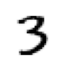

In [12]:
a_3 = stacked_threes[1]
show_image(a_3);

Let's calculate the difference between the digit above and idea one using both ways

In [13]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

Let's try the same but with seven

In [14]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

Lets calculate metrics to measure how good our model is. To do that we need to have a validation set to compare with

In [15]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

It's good to get in the habit of checking shapes as you go. Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

We can write a simple function that calculates the mean absolute error:

In [16]:
def mnist_distance(a, b): return ((a - b)**2).mean((-1, -2)).sqrt()

Our function calls mean((-1,-2)). The tuple (-1,-2) represents a range of axes. In Python, -1 refers to the last element, and -2 refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. 

In [17]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

Function above checks if an argument is 3. Let's check how it works:

In [18]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [19]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

In [20]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9584), tensor(0.9737), tensor(0.9661))

Formulas above are working, but they are very basic and we cannot improve the accuracy. 

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

```
def pr_eight(x,w) = (x*w).sum()
```

Here we are assuming that `x` is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector `w`. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

In [21]:
# TBD: Explain why we need derivative for parameters

### An End-to-End SGD Example

In [22]:
# Let's define our input

time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

Let's define function that will be modelling the process:

In [23]:
def func(input, params):
    a,b,c = params
    return a*(input**2) + b*input + c

In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best *quadratic* function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`. Thus, to find the best quadratic function, we only need to find the best values for `a`, `b`, and `c`.

If we can solve this problem for the three parameters of a quadratic function, we'll be able to apply the same approach for other, more complex functions with more parameters—such as a neural net. Let's find the parameters for `f` first, and then we'll come back and do the same thing for the MNIST dataset with a neural net.

We need to define first what we mean by "best." We define this precisely by choosing a *loss function*, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. For continuous data, it's common to use *mean squared error*:

In [24]:
def mse(preds, targets): return ((preds-targets)**2).mean()

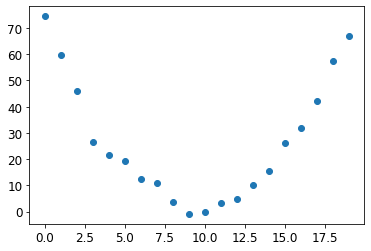

In [25]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

Let's initialize params. We are going to adjust them, so they can be random initialy:

In [26]:
params = torch.randn(3).requires_grad_()

In [27]:
#hide
orig_params = params.clone()

In [28]:
# Calculate predictions

preds = func(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [29]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

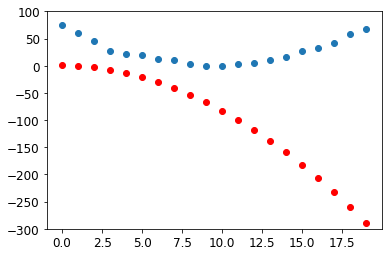

In [30]:
show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds! 

#### Step 3: Calculate the loss

In [31]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.

#### Step 4: Calculate the gradients

We perform backard on loss to calculate parameters change. Because loss if function value and we need to find how params will change by performing gradint calculation (derivative)

In [32]:
loss.backward() 
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [33]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [34]:
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

#### Step 5: Step the weights.

In [35]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None # this needs to be done constantly

> a: Understanding this bit depends on remembering recent history. To calculate the gradients we call `backward` on the `loss`. But this `loss` was itself calculated by `mse`, which in turn took `preds` as an input, which was calculated using `f` taking as an input `params`, which was the object on which we originally called `required_grads_`—which is the original call that now allows us to call `backward` on `loss`. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

Let's see if the loss has improved:

In [36]:
preds = func(time,params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

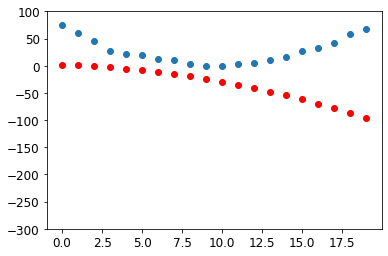

In [37]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

In [38]:
def apply_step(params, prn=True):
    preds = func(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process

In [39]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

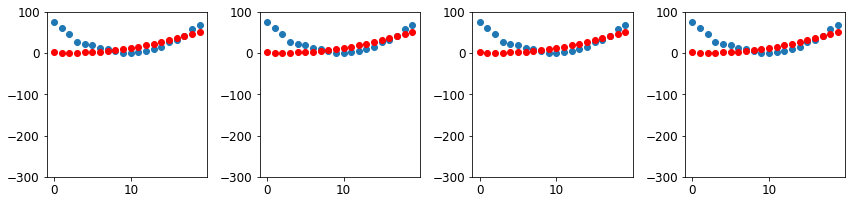

In [40]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

In [41]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

# LET'S TALK BUSINESS....


Let's try implementing learner

First, we need to get our stacked tensors and "unfold" them by converting square images into vectors, by stacking each new row in the end of previous one using pytorch ```view``` function.

We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data":

In [42]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a label for each image. We'll use `1` for 3s and `0` for 7s:

In [43]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [44]:
dset = list(zip(train_x, train_y))

In [45]:
x,y = dset[0]
x.shape,y       # 28*28=784, so it is one image and a label 

(torch.Size([784]), tensor([1]))

Let's do the same stuff for validation set

In [46]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel (this is the initialize step in our seven-step process):

In [47]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [48]:
weights = init_params((28*28,1))

The function ```weights*pixels``` won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0). You might remember from high school math that the formula for a line is y=w*x+b; we still need the b. We'll initialize it to a random number too:

In [49]:
bias = init_params(1)

In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

Let's try using linear function to make predictions. Because image is a tensor now (vector) and params as well we need to multiply matrixes:

In [50]:
def linear1(xb): return xb@weights + bias

In [51]:
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [52]:
corrects = (preds > 0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [53]:
corrects.float().mean().item()

0.4912068545818329

Here's a first try at a loss function that measures the distance between predictions and targets:

In [54]:
def mnist_loss(preds, targets): 
    return torch.where(targets==1, 1-preds, preds).mean()

We're using a new function, torch.where(a,b,c). This is the same as running the list comprehension [b[i] if a[i] else c[i] for i in range(len(a))], except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.


One problem with mnist_loss as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case by using sigmoid.

In [55]:
def sigmoid(x): return 1/(1+torch.exp(-x))

/usr/local/lib/python3.7/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


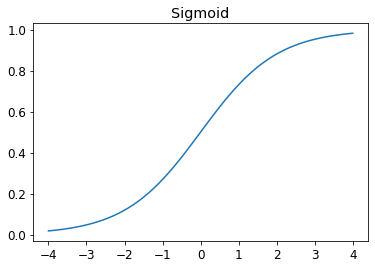

In [56]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients.

Let's update mnist_loss to first apply sigmoid to the inputs:

In [57]:
def mnist_loss(preds, targets): 
    preds = preds.sigmoid()
    return torch.where(targets==1, 1-preds, preds).mean()

To get better results, we, instead of throwing the same data to our learning function each time, can use mini-batches and ```DataLoader``` can help us with it.

In [58]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

# Loader implementation. Finally.

First, let's re-initialize our parameters:

In [59]:
weights = init_params((28*28,1))
bias = init_params(1)

A `DataLoader` can be created from a `Dataset`:

In [60]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set:

In [61]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [62]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

Let's test our gradient calc function.

In [63]:
batch = train_x[:4]
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-2.7033e-05), tensor([-0.0002]))

In [64]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-5.4066e-05), tensor([-0.0004]))

The gradients have changed! The reason for this is that loss.backward actually adds the gradients of loss to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [65]:
weights.grad.zero_()
bias.grad.zero_();

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the data attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [66]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

In [67]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [68]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [69]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [70]:
validate_epoch(linear1)

0.2876

In [71]:
# Let's train one epoch
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.512

In [72]:
# Few more:
for i in range(40):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6682 0.8144 0.9042 0.9311 0.9433 0.951 0.9554 0.9598 0.9657 0.9667 0.9677 0.9687 0.9691 0.9691 0.9696 0.9701 0.9701 0.9706 0.9716 0.9716 0.9726 0.973 0.973 0.973 0.973 0.973 0.974 0.974 0.975 0.975 0.975 0.975 0.9755 0.9755 0.9755 0.9755 0.976 0.976 0.976 0.976 

# Here we go

In [73]:
class MyLinear:
    def __init__(self, size, bs):
        self.weights = self.__init_params(size)
        self.bias = self.__init_params(bs)
        self.params = self.weights, self.bias
        
    def __init_params(self, sz, std=1.0): return (torch.randn(sz)*std).requires_grad_()
    
    def __call__(self, xb):
        return self.linear1(xb)
    
    def linear1(self, xb): return xb@self.weights + self.bias
    
    
class MyLearner:
    def __init__(self, dls, model, opt_func, loss_function, metrics): 
        self.dls = dls
        self.model = model
        self.opt_func = opt_func
        self.loss_function = loss_function
        self.metrics = metrics
        
    def __calc_grad(self, xb, yb):
        self.preds = self.model(xb)
        self.loss = self.loss_function(self.preds, yb)
        self.loss.backward()
        
    def __train_epoch(self, lr):
        for xb, yb in self.dls.train:
            self.__calc_grad(xb, yb)
#            self.opt_func(self.model.params, lr)

            for p in self.model.params: 
                p.data -= p.grad * lr
                p.grad.zero_()
        
    def __validate_epoch(self):
        accs = [self.metrics(self.model(xb), yb) for xb,yb in self.dls.valid]
        return round(torch.stack(accs).mean().item(), 4)
        
    def fit(self, epochs, lr):
        for i in range(epochs):
            self.__train_epoch(lr)
            print(self.__validate_epoch(), end=' ')

In [74]:
model = MyLinear((28*28, 1), 1)

In [75]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [76]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [77]:
dls = DataLoaders(dl, valid_dl)

In [78]:
learner = MyLearner(dls, model, opt_func=SGD,
                loss_function=mnist_loss, metrics=batch_accuracy)

learner.fit(150, 1.)

0.7104 0.8613 0.9096 0.9335 0.9448 0.9555 0.9589 0.9618 0.9638 0.9667 0.9672 0.9682 0.9691 0.9696 0.9696 0.9701 0.9706 0.9706 0.9706 0.9706 0.9711 0.9706 0.9706 0.9706 0.9711 0.9711 0.9716 0.972 0.973 0.9725 0.9725 0.973 0.9735 0.974 0.974 0.9745 0.975 0.975 0.975 0.975 0.976 0.976 0.9765 0.977 0.977 0.9774 0.9774 0.9784 0.9784 0.9789 0.9789 0.9789 0.9789 0.9789 0.9784 0.9789 0.9794 0.9794 0.9794 0.9794 0.9794 0.9799 0.9799 0.9799 0.9799 0.9799 0.9799 0.9799 0.9804 0.9804 0.9804 0.9804 0.9804 0.9804 0.9804 0.9804 0.9804 0.9804 0.9804 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.9823 0.9823 0.9828 0.9828 0.9828 0.9828 0.9833 0.9833 0.9833 0.9838 0.9838 0.9838 0.9843 0.9843 0.9843 0.9843 0.9843 0.9843 0.9843 0.9843 0.9843 0.9843 0.9843 0.9848 0.9848 0.9848 0.9848 0.9848 0.984